In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pathlib import Path
import sys
# Set sys path
sys.path.append(str(Path(os.getcwd()).parent))

In [3]:
# Adjust matplotlib settings for font inclusion
plt.rcParams['pdf.fonttype'] = 42  # Use Type 3 (PostScript) fonts
plt.rcParams['ps.fonttype'] = 42

# Set filpaths for data and figures
notebook_dir = os.getcwd()
file_path = Path(notebook_dir).parent / 'data' 

# Load Data

In [4]:
df = pd.read_csv(file_path / "AD_CSF_Sweden+MagKiel.pg_matrix.tsv", sep='\t')
gene_dict = dict(zip(df['Protein.Group'], df['Genes']))
prot = df.set_index('Protein.Group').iloc[:,4:].T
prot.index = [a.split('/')[-1] for a in prot.index]
prot.index = [a.split('.')[0] for a in prot.index]
prot = np.log10(prot.replace(0, np.nan))

In [5]:
d_Berlin = pd.read_csv(file_path / 'AD_CSF_Berlin_Sw+MK_speclib.tsv', sep='\t')
d_Berlin_prot = d_Berlin.set_index('Protein.Group').iloc[:,4:].T
d_Berlin_prot.index = [a.split('/')[-1] for a in d_Berlin_prot.index]
d_Berlin_prot.index = [a.split('.')[0] for a in d_Berlin_prot.index]
d_Berlin_prot = np.log10(d_Berlin_prot.replace(0, np.nan))

In [6]:
d_groups = pd.read_excel(file_path / "annotation of samples_AM1.5.11.xlsx")
d_groups = d_groups.dropna(subset='sample name')
cat = d_groups.set_index('sample name')[['biochemical AD classification']]
cat.index = [a.split('.')[0] for a in cat.index]

# Berlin cohort

In [8]:
# Find shared columns
shared_columns = prot.columns.intersection(d_Berlin_prot.columns)

# Keep only shared columns in both DataFrames
prot_shared = prot[shared_columns]
d_Berlin_prot_shared = d_Berlin_prot[shared_columns]

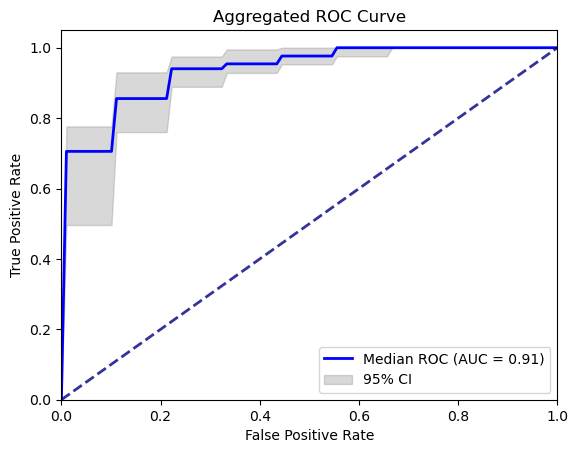

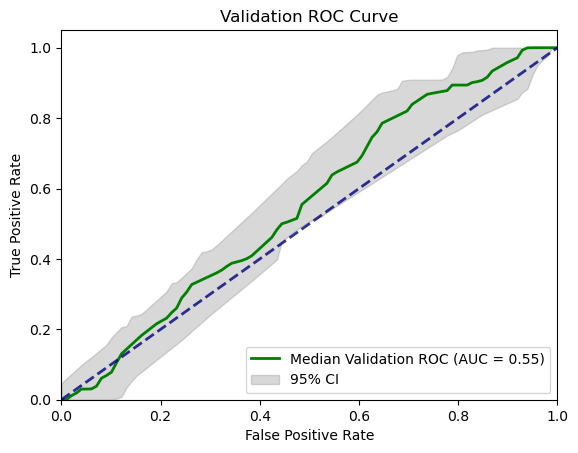

In [9]:
from utils.BaselineClassifier import BaselineClassifier
# Initialize the classifier
baseline = BaselineClassifier(prot_shared, cat, gene_dict, between='biochemical AD classification')

# Perform classification 10 times and plot the aggregated ROC curve
baseline.classify_and_plot('biochemical control', 'biochemical AD', n_runs=10, n_estimators=50)
baseline.validate_and_plot(d_Berlin_prot_shared, cat, 'biochemical control', 'biochemical AD')

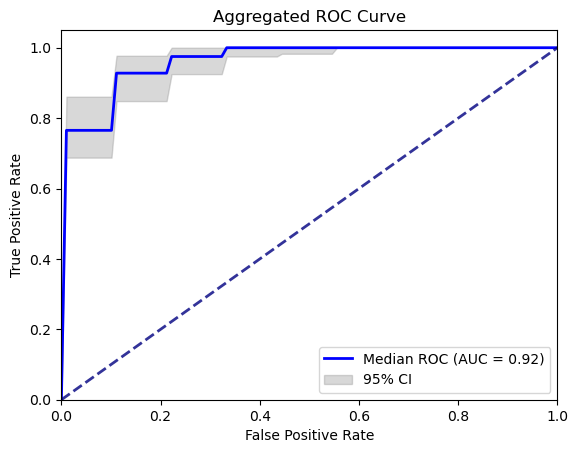

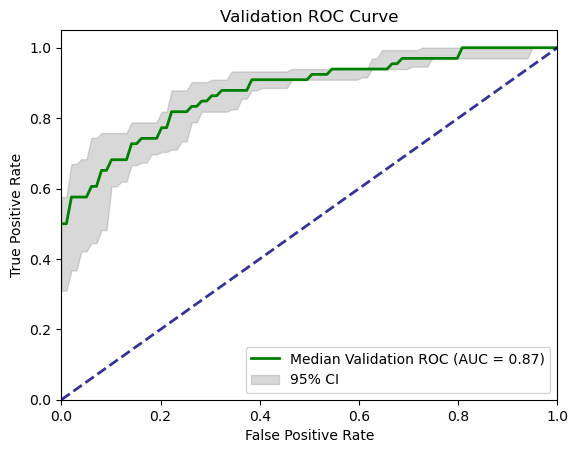

In [10]:
from utils.NonRefitClassifier import NonRefitClassifier
# Initialize the classifier
no_refit = NonRefitClassifier(prot_shared, cat, gene_dict, between='biochemical AD classification')

# Perform classification 10 times and plot the aggregated ROC curve
no_refit.classify_and_plot('biochemical control', 'biochemical AD')
no_refit.validate_and_plot(d_Berlin_prot_shared, cat, 'biochemical control', 'biochemical AD')

# Berlin ADAPT-MS

In [11]:
cat_Berlin = cat.copy()
cat_Berlin.index = [a+'.mzML' for a in cat_Berlin.index]

In [ ]:
from utils.AdaptmsClassifier import AdaptmsClassifierFolder
#Initialize the classifier
adaptms = AdaptmsClassifierFolder(prot, cat, gene_dict, between='biochemical AD classification')

#Perform classification 10 times and plot the aggregated ROC curve
adaptms.classify_and_plot('biochemical control', 'biochemical AD', n_runs=10, topn_features=80)

#Perform verification on 10 selected models and plot the aggregated ROC curve
adaptms.classify_directory(file_path / 'Single_file_results/Train_sweden+MagKiel_apply_to_Berlin', cat_Berlin, 'biochemical control', 'biochemical AD')
adaptms.plot_accumulated_roc('biochemical control', 'biochemical AD')